### Notebook to calculate image-by-image zeropoints. 

In [60]:
#standard imports
%matplotlib inline
import numpy as np

from astroquery.vizier import Vizier
import astropy.coordinates as coords
from astropy.coordinates import Angle
import astropy.units as u

import matplotlib.pyplot as plt
import seaborn as sea

Vizier.ROW_LIMIT = 999999999

def write_reg(ra,dec,size='2"',color='green',shape='circle',filename='regions.reg', width=1):
    f = open(filename,'w')
    f.write('fk5\n')
    for i,j in zip(ra,dec):
        f.write(shape+' '+str(i)+' '+str(j)+' '+size+' # color='+color+ ' width='+str(width)+'\n')
    f.close()     

## Query Vizier to select all SDSS sources about the images. 

In [88]:
#specify the ra and dec to search about. Just pick coordinates in the middle of the image.
search_ra = 202.09615 *u.degree
search_dec = 21.000972 * u.degree

#specify the search radius, just pick big enough region. Needs to be bigger for CFHT imaging compared to SDSS.
search_rad = 1.5 * u.degree

#specify the filter to use for sdss (i.e. 'gmag','rmag','imag')
filt = 'g'

#specify the bright and faint cuts for sdss phot comparison (these should be fairly constant across images)
sdss_faint_cut = 20
sdss_bright_cut = 12

#specify the data file that contains our photometry
phot_file = 'bg1_g_uncorrected.csv'

#specify the cuts for our photometry to calcualte zero-points. These should probably match those used for 
#calculating the aperture corrections.
fwhm_max = 5.0
fwhm_min = 4.1
faint_cut = 21
bright_cut = 10

#specify the aperture correction that we use for this image.
aper_cor = 0.3429

#fg extinction: input the foreground extinction for this particular filter at this pointing. reasonable approxiamtion
#to just take constant value from NASA NED.
fg_extinction = 0.065

#specify the initial zeropoint that was used for initial photometry. this is whatever is in the .seconfig file
#for aperture corrections.
init_zpt = 30.0

In [62]:
#perform the vizier query
pos = coords.SkyCoord(ra=search_ra, dec=search_dec, frame='icrs')
result = Vizier.query_region(pos, radius=search_rad, catalog='SDSS')

ra = result[0]['_RAJ2000']
dec = result[0]['_DEJ2000']

In [89]:
#Select reasonable stars from SDSS for zero-point comparisons. Also, only select
#stars to do the comparison (SDSS class ==6)
good_sdss_sources = (result[0]['cl'] == 6) & \
    (result[0][filt+'mag'] < sdss_faint_cut) & (result[0][filt+'mag'] > sdss_bright_cut)

In [90]:
#print out the number of good comparisons for testing purposes
np.sum(good_sdss_sources)

8540

In [91]:
#write out a region file containing the good comparisons, for reference
write_reg(ra[good_sdss_sources],dec[good_sdss_sources],filename='sdss_matched_'+filt+'.reg',width=5,size='5"')

In [92]:
#read in our photometry
data = np.loadtxt(phot_file,delimiter=',')

In [93]:
#cut our data to select only good comparison stars.
good_data = (data[:,2] < faint_cut) & (data[:,2] > bright_cut) & \
    (data[:,4] > fwhm_min) & (data[:,4] < fwhm_max) & (data[:,6] < 1)
    
cut_data = data[good_data,:]

#apply aperture corrections to our measured photometry
cut_data[:,2] = cut_data[:,2] - aper_cor 

In [94]:
#match our photometry with corresponding sources in SDSS
ra_meas = cut_data[:,0]
dec_meas = cut_data[:,1]

measured_coords = coords.SkyCoord(ra=ra_meas*u.degree,\
    dec=dec_meas*u.degree)

sdss_coords = coords.SkyCoord(ra=ra[good_sdss_sources],dec=dec[good_sdss_sources])

full_old,full_new,d2d,d3d = sdss_coords.search_around_sky(measured_coords,0.1*u.arcsec)

In [95]:
#calculate differences between our measured photometry
diffs = cut_data[full_old,2] - (result[0][filt+'mag'][good_sdss_sources][full_new])
                      # - 0.085*(result[0]['rmag'][good_comps][full_new] - result[0]['imag'][good_comps][full_new]))

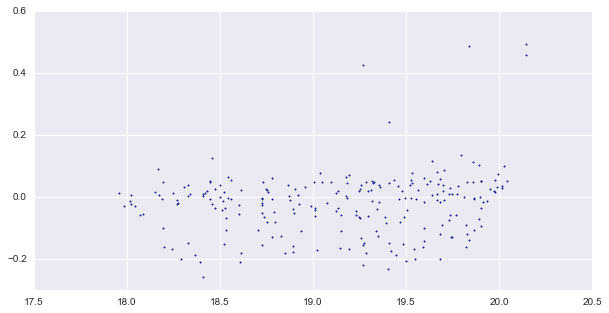

In [96]:

fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(cut_data[full_old,2],diffs,s=2)


### Calculate the final shift. Actual zeropoint is whatever was used to make initial catalog plus the below value.

In [71]:
zpt_shift = np.median(diffs)
print('Zero-point shift: ',zpt_shift)
print('New zero-point: ',zpt_shift + init_zpts)

Zero-point shift:  -0.0373001373291


NameError: name 'init_zpts' is not defined